# Investigate number of past observations needed for estimation of current count

## First use recent observations as test set

In [6]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch, random, os, numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"
DOW = True

dataset= get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, dow = DOW)
train_idcs, test_idcs = range(2133), range(2133, dataset.__len__()) # 2844 total obs - 711 test, still 25% even without random split dataset.__len__(), 2353
train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)

## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=len(val_idcs), sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=len(test_idcs), sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seeds(SEED)

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:102: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


Könnte idcs einfach komplett gleich lassen, nur jedes Mal shiften um die Differenz (+(alt- neu)), dann train, test etc. identisch, nur andere Form

Sequential wieder

In [27]:
%load_ext autoreload
%autoreload 3
from NowcastPNN import NowcastPNNDOW
from train_utils import train, EarlyStopper
from metrics import evaluate_PIs, pnn_PIs
set_seeds(SEED)

n_past_units = [40, 35, 30, 25, 20, 15, 10, 5]
pnn_coverages, pnn_picas, pnn_wis, pnn_is_decomp = [], [], [], []
for pu in n_past_units:
    dataset= get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=pu, max_delay=MAX_DELAY, state=STATE, dow = DOW)
    if pu < 40:
        train_idcs = [*range(5), *[x+5 for x in train_idcs]]
        val_idcs = [x+5 for x in val_idcs]
        test_idcs = [x+5 for x in test_idcs]
    g = torch.Generator()
    g.manual_seed(SEED)
    temp_train_sampler, temp_val_sampler, temp_test_sampler= SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
    temp_train_loader, temp_val_loader, temp_test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=temp_train_sampler), DataLoader(dataset, batch_size=len(val_idcs), sampler=temp_val_sampler, shuffle=False), DataLoader(dataset, batch_size=len(test_idcs), sampler=temp_test_sampler, shuffle=False)
    print(f"##################### Number past units: {pu} #####################")
    early_stopper = EarlyStopper(patience=30, past_units=pu, max_delay=MAX_DELAY, weeks=WEEKS, random_split=RANDOM_SPLIT, dow = DOW)
    nowcast_pnn = NowcastPNNDOW(past_units=pu, max_delay=MAX_DELAY, embedding_dim=10)
    train(nowcast_pnn, num_epochs=200, train_loader=temp_train_loader, val_loader=temp_val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE, dow = DOW)
    nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{pu}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))
    temp_levels_pnn = pnn_PIs(nowcast_pnn, temp_test_loader, random_split = RANDOM_SPLIT, save=False, dow = DOW) 
    temp_pnn_dict = evaluate_PIs(temp_levels_pnn, temp_test_loader)
    pnn_coverages.append(temp_pnn_dict["coverages"])
    pnn_picas.append(temp_pnn_dict["pica"])
    pnn_wis.append(temp_pnn_dict["wis"])
    pnn_is_decomp.append(temp_pnn_dict["is"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 40 #####################
Epoch 1 - Train loss: 2.57e+05 - Val loss: 2.3e+06 - ES count: 0
Epoch 2 - Train loss: 2.48e+05 - Val loss: 2.3e+06 - ES count: 0
Epoch 3 - Train loss: 2.44e+05 - Val loss: 2.11e+06 - ES count: 0
Epoch 4 - Train loss: 2.4e+05 - Val loss: 1.95e+06 - ES count: 0
Epoch 5 - Train loss: 2.36e+05 - Val loss: 1.92e+06 - ES count: 0
Epoch 6 - Train loss: 2.32e+05 - Val loss: 1.85e+06 - ES count: 0
Epoch 7 - Train loss: 2.28e+05 - Val loss: 1.95e+06 - ES count: 1
Epoch 8 - Train loss: 2.24e+05 - Val loss: 1.78e+06 - ES count: 0
Epoch 9 - Train loss: 2.19e+05 - Val loss: 1.83e+06 - ES count: 1
Epoch 10 - Train loss: 2.14e+05 - Val loss: 1.73e+06 - ES count: 0
Epoch 11 - Train loss: 2.08e+05 - Val loss: 1.74e+06 - ES count: 1
Epoch 12 - Train loss: 2.03e+05 - Val loss: 1.55e+06 - ES count: 0
Epoch 13 - Train loss: 1.97e+05 - Val loss: 1.68e+06 - ES count: 1
Epoch 14 - Train loss: 1.91e+0

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 35 #####################
Epoch 1 - Train loss: 3.46e+05 - Val loss: 2.55e+06 - ES count: 0
Epoch 2 - Train loss: 3.3e+05 - Val loss: 2.51e+06 - ES count: 0
Epoch 3 - Train loss: 3.24e+05 - Val loss: 2.68e+06 - ES count: 1
Epoch 4 - Train loss: 3.18e+05 - Val loss: 2.59e+06 - ES count: 2
Epoch 5 - Train loss: 3.14e+05 - Val loss: 2.61e+06 - ES count: 3
Epoch 6 - Train loss: 3.09e+05 - Val loss: 2.61e+06 - ES count: 4
Epoch 7 - Train loss: 3.04e+05 - Val loss: 2.49e+06 - ES count: 0
Epoch 8 - Train loss: 2.98e+05 - Val loss: 2.47e+06 - ES count: 0
Epoch 9 - Train loss: 2.93e+05 - Val loss: 2.45e+06 - ES count: 0
Epoch 10 - Train loss: 2.87e+05 - Val loss: 2.23e+06 - ES count: 0
Epoch 11 - Train loss: 2.81e+05 - Val loss: 2.38e+06 - ES count: 1
Epoch 12 - Train loss: 2.73e+05 - Val loss: 2.27e+06 - ES count: 2
Epoch 13 - Train loss: 2.65e+05 - Val loss: 2.19e+06 - ES count: 0
Epoch 14 - Train loss: 2.59e

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 30 #####################
Epoch 1 - Train loss: 2.65e+05 - Val loss: 2.54e+06 - ES count: 0
Epoch 2 - Train loss: 2.51e+05 - Val loss: 2.24e+06 - ES count: 0
Epoch 3 - Train loss: 2.45e+05 - Val loss: 2e+06 - ES count: 0
Epoch 4 - Train loss: 2.4e+05 - Val loss: 2.01e+06 - ES count: 1
Epoch 5 - Train loss: 2.35e+05 - Val loss: 1.93e+06 - ES count: 0
Epoch 6 - Train loss: 2.31e+05 - Val loss: 1.87e+06 - ES count: 0
Epoch 7 - Train loss: 2.26e+05 - Val loss: 1.78e+06 - ES count: 0
Epoch 8 - Train loss: 2.21e+05 - Val loss: 1.75e+06 - ES count: 0
Epoch 9 - Train loss: 2.16e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 10 - Train loss: 2.1e+05 - Val loss: 1.71e+06 - ES count: 0
Epoch 11 - Train loss: 2.06e+05 - Val loss: 1.55e+06 - ES count: 0
Epoch 12 - Train loss: 2e+05 - Val loss: 1.57e+06 - ES count: 1
Epoch 13 - Train loss: 1.94e+05 - Val loss: 1.58e+06 - ES count: 2
Epoch 14 - Train loss: 1.88e+05 - V

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 25 #####################
Epoch 1 - Train loss: 3.58e+05 - Val loss: 2.97e+06 - ES count: 0
Epoch 2 - Train loss: 3.46e+05 - Val loss: 2.97e+06 - ES count: 0
Epoch 3 - Train loss: 3.39e+05 - Val loss: 2.82e+06 - ES count: 0
Epoch 4 - Train loss: 3.33e+05 - Val loss: 2.88e+06 - ES count: 1
Epoch 5 - Train loss: 3.27e+05 - Val loss: 2.69e+06 - ES count: 0
Epoch 6 - Train loss: 3.2e+05 - Val loss: 2.71e+06 - ES count: 1
Epoch 7 - Train loss: 3.13e+05 - Val loss: 2.7e+06 - ES count: 2
Epoch 8 - Train loss: 3.06e+05 - Val loss: 2.62e+06 - ES count: 0
Epoch 9 - Train loss: 2.98e+05 - Val loss: 2.53e+06 - ES count: 0
Epoch 10 - Train loss: 2.91e+05 - Val loss: 2.39e+06 - ES count: 0
Epoch 11 - Train loss: 2.83e+05 - Val loss: 2.38e+06 - ES count: 0
Epoch 12 - Train loss: 2.75e+05 - Val loss: 2.19e+06 - ES count: 0
Epoch 13 - Train loss: 2.66e+05 - Val loss: 2.15e+06 - ES count: 0
Epoch 14 - Train loss: 2.57e+

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 20 #####################
Epoch 1 - Train loss: 2.67e+05 - Val loss: 2.51e+06 - ES count: 0
Epoch 2 - Train loss: 2.45e+05 - Val loss: 2.14e+06 - ES count: 0
Epoch 3 - Train loss: 2.38e+05 - Val loss: 1.84e+06 - ES count: 0
Epoch 4 - Train loss: 2.32e+05 - Val loss: 1.93e+06 - ES count: 1
Epoch 5 - Train loss: 2.26e+05 - Val loss: 1.85e+06 - ES count: 2
Epoch 6 - Train loss: 2.19e+05 - Val loss: 1.77e+06 - ES count: 0
Epoch 7 - Train loss: 2.13e+05 - Val loss: 1.69e+06 - ES count: 0
Epoch 8 - Train loss: 2.07e+05 - Val loss: 1.59e+06 - ES count: 0
Epoch 9 - Train loss: 2.02e+05 - Val loss: 1.65e+06 - ES count: 1
Epoch 10 - Train loss: 1.95e+05 - Val loss: 1.56e+06 - ES count: 0
Epoch 11 - Train loss: 1.89e+05 - Val loss: 1.52e+06 - ES count: 0
Epoch 12 - Train loss: 1.82e+05 - Val loss: 1.42e+06 - ES count: 0
Epoch 13 - Train loss: 1.75e+05 - Val loss: 1.41e+06 - ES count: 0
Epoch 14 - Train loss: 1.7e

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 15 #####################
Epoch 1 - Train loss: 4.09e+05 - Val loss: 3.43e+06 - ES count: 0
Epoch 2 - Train loss: 3.83e+05 - Val loss: 3.27e+06 - ES count: 0
Epoch 3 - Train loss: 3.71e+05 - Val loss: 2.74e+06 - ES count: 0
Epoch 4 - Train loss: 3.61e+05 - Val loss: 3.08e+06 - ES count: 1
Epoch 5 - Train loss: 3.53e+05 - Val loss: 2.78e+06 - ES count: 2
Epoch 6 - Train loss: 3.46e+05 - Val loss: 2.87e+06 - ES count: 3
Epoch 7 - Train loss: 3.39e+05 - Val loss: 2.75e+06 - ES count: 4
Epoch 8 - Train loss: 3.29e+05 - Val loss: 2.8e+06 - ES count: 5
Epoch 9 - Train loss: 3.22e+05 - Val loss: 2.73e+06 - ES count: 0
Epoch 10 - Train loss: 3.14e+05 - Val loss: 2.53e+06 - ES count: 0
Epoch 11 - Train loss: 3.05e+05 - Val loss: 2.64e+06 - ES count: 1
Epoch 12 - Train loss: 2.96e+05 - Val loss: 2.36e+06 - ES count: 0
Epoch 13 - Train loss: 2.88e+05 - Val loss: 2.35e+06 - ES count: 0
Epoch 14 - Train loss: 2.78e

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 10 #####################
Epoch 1 - Train loss: 2.59e+05 - Val loss: 2.11e+06 - ES count: 0
Epoch 2 - Train loss: 2.38e+05 - Val loss: 1.99e+06 - ES count: 0
Epoch 3 - Train loss: 2.31e+05 - Val loss: 1.82e+06 - ES count: 0
Epoch 4 - Train loss: 2.26e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 5 - Train loss: 2.2e+05 - Val loss: 1.94e+06 - ES count: 1
Epoch 6 - Train loss: 2.15e+05 - Val loss: 1.63e+06 - ES count: 0
Epoch 7 - Train loss: 2.11e+05 - Val loss: 1.61e+06 - ES count: 0
Epoch 8 - Train loss: 2.05e+05 - Val loss: 1.68e+06 - ES count: 1
Epoch 9 - Train loss: 2e+05 - Val loss: 1.66e+06 - ES count: 2
Epoch 10 - Train loss: 1.94e+05 - Val loss: 1.59e+06 - ES count: 0
Epoch 11 - Train loss: 1.89e+05 - Val loss: 1.55e+06 - ES count: 0
Epoch 12 - Train loss: 1.84e+05 - Val loss: 1.47e+06 - ES count: 0
Epoch 13 - Train loss: 1.78e+05 - Val loss: 1.45e+06 - ES count: 0
Epoch 14 - Train loss: 1.71e+05

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 5 #####################
Epoch 1 - Train loss: 4.12e+05 - Val loss: 3.94e+06 - ES count: 0
Epoch 2 - Train loss: 3.95e+05 - Val loss: 3.37e+06 - ES count: 0
Epoch 3 - Train loss: 3.87e+05 - Val loss: 3.38e+06 - ES count: 1
Epoch 4 - Train loss: 3.79e+05 - Val loss: 3.48e+06 - ES count: 2
Epoch 5 - Train loss: 3.73e+05 - Val loss: 3.4e+06 - ES count: 3
Epoch 6 - Train loss: 3.66e+05 - Val loss: 3.28e+06 - ES count: 0
Epoch 7 - Train loss: 3.6e+05 - Val loss: 2.92e+06 - ES count: 0
Epoch 8 - Train loss: 3.53e+05 - Val loss: 1.96e+06 - ES count: 0
Epoch 9 - Train loss: 3.47e+05 - Val loss: 3.13e+06 - ES count: 1
Epoch 10 - Train loss: 3.39e+05 - Val loss: 2.94e+06 - ES count: 2
Epoch 11 - Train loss: 3.31e+05 - Val loss: 2.62e+06 - ES count: 3
Epoch 12 - Train loss: 3.23e+05 - Val loss: 2.72e+06 - ES count: 4
Epoch 13 - Train loss: 3.14e+05 - Val loss: 2.6e+06 - ES count: 5
Epoch 14 - Train loss: 3.04e+05

## Plot scores over time

potentially do 2 2x1 graphics instead of 3x1 due to size of fonts

### IS, WIS and coverages
Same as n_training, just here for past units

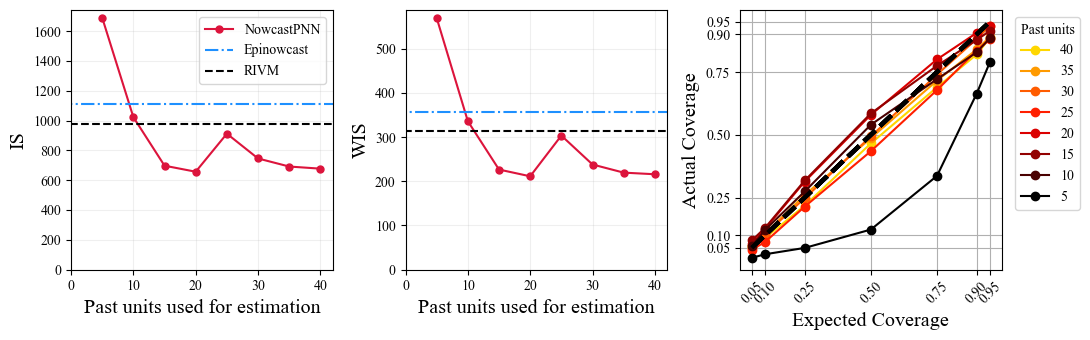

In [47]:
from plotting import plot_past_units_is_wis_covs
plot_past_units_is_wis_covs(n_past_units=n_past_units, pnn_is_decomp=pnn_is_decomp, pnn_wis=pnn_wis, pnn_coverages=pnn_coverages, save = True, random_split = False)

## Plot with randomly split data

In [48]:
RANDOM_SPLIT = True
# could reload to always ensure correct size/length
all_idcs_rand = range(dataset.__len__())
train_idcs_rand_total, test_idcs_rand = TTS(all_idcs_rand, test_size=0.25, shuffle=True, random_state=SEED)
train_idcs_rand, val_idcs_rand = TTS(train_idcs_rand_total, test_size=0.25, shuffle=True, random_state=SEED)

test_sampler_rand = SS(test_idcs_rand)
test_loader_rand = DataLoader(dataset, batch_size=len(test_idcs_rand), sampler=test_sampler_rand, shuffle=False)

In [49]:
set_seeds(SEED)

n_past_units = [40, 35, 30, 25, 20, 15, 10, 5]
pnn_coverages_rand, pnn_picas_rand, pnn_wis_rand, pnn_is_decomp_rand = [], [], [], []
for pu in n_past_units:
    dataset= get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=pu, max_delay=MAX_DELAY, state=STATE, dow = DOW)
    if pu < 40:
        train_idcs_rand = [*range(5), *[x+5 for x in train_idcs_rand]]
        val_idcs_rand = [x+5 for x in val_idcs_rand]
        test_idcs_rand = [x+5 for x in test_idcs_rand]
    g = torch.Generator()
    g.manual_seed(SEED)
    temp_train_sampler, temp_val_sampler, temp_test_sampler= SRS(train_idcs_rand, generator=g), SRS(val_idcs_rand), SS(test_idcs_rand)
    temp_train_loader, temp_val_loader, temp_test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=temp_train_sampler), DataLoader(dataset, batch_size=len(val_idcs_rand), sampler=temp_val_sampler, shuffle=False), DataLoader(dataset, batch_size=len(test_idcs_rand), sampler=temp_test_sampler, shuffle=False)
    print(f"##################### Number past units: {pu} #####################")
    early_stopper = EarlyStopper(patience=30, past_units=pu, max_delay=MAX_DELAY, weeks=WEEKS, random_split=RANDOM_SPLIT, dow = DOW)
    nowcast_pnn_rand = NowcastPNNDOW(past_units=pu, max_delay=MAX_DELAY, embedding_dim=10, dropout_probs=[0.3, 0.1])
    if pu != 40:
        train(nowcast_pnn_rand, num_epochs=200, train_loader=temp_train_loader, val_loader=temp_val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE, dow = DOW)
    nowcast_pnn_rand.load_state_dict(torch.load(f"./weights/weights-{pu}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))
    temp_levels_pnn = pnn_PIs(nowcast_pnn_rand, temp_test_loader, random_split = RANDOM_SPLIT, save=False, dow = DOW) 
    temp_pnn_dict = evaluate_PIs(temp_levels_pnn, temp_test_loader)
    pnn_coverages_rand.append(temp_pnn_dict["coverages"])
    pnn_picas_rand.append(temp_pnn_dict["pica"])
    pnn_wis_rand.append(temp_pnn_dict["wis"])
    pnn_is_decomp_rand.append(temp_pnn_dict["is"])

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 40 #####################
Actual coverage per level | 5%: 5.83 | 10%: 10.83 | 25%: 27.22 | 50%: 50.97 | 75%: 73.33 | 90%: 85.14 | 95%: 89.31 |
PICA: 0.024404761904761898
WIS: 171.93189490537685
IS: under = 124.19373781676414 | spread = 327.94008432539675 | over = 90.60060568086884 | total = 542.7344278230297


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 35 #####################
Epoch 1 - Train loss: 3.31e+05 - Val loss: 2.93e+06 - ES count: 0
Epoch 2 - Train loss: 3.15e+05 - Val loss: 2.6e+06 - ES count: 0
Epoch 3 - Train loss: 3.06e+05 - Val loss: 2.35e+06 - ES count: 0
Epoch 4 - Train loss: 2.97e+05 - Val loss: 2.33e+06 - ES count: 0
Epoch 5 - Train loss: 2.9e+05 - Val loss: 2.28e+06 - ES count: 0
Epoch 6 - Train loss: 2.84e+05 - Val loss: 2.26e+06 - ES count: 0
Epoch 7 - Train loss: 2.77e+05 - Val loss: 2.18e+06 - ES count: 0
Epoch 8 - Train loss: 2.7e+05 - Val loss: 2.21e+06 - ES count: 1
Epoch 9 - Train loss: 2.62e+05 - Val loss: 2.1e+06 - ES count: 0
Epoch 10 - Train loss: 2.54e+05 - Val loss: 2.04e+06 - ES count: 0
Epoch 11 - Train loss: 2.47e+05 - Val loss: 1.99e+06 - ES count: 0
Epoch 12 - Train loss: 2.39e+05 - Val loss: 1.94e+06 - ES count: 0
Epoch 13 - Train loss: 2.32e+05 - Val loss: 1.84e+06 - ES count: 0
Epoch 14 - Train loss: 2.23e+05

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 30 #####################
Epoch 1 - Train loss: 2.66e+05 - Val loss: 2.38e+06 - ES count: 0
Epoch 2 - Train loss: 2.55e+05 - Val loss: 2.28e+06 - ES count: 0
Epoch 3 - Train loss: 2.49e+05 - Val loss: 2.11e+06 - ES count: 0
Epoch 4 - Train loss: 2.45e+05 - Val loss: 1.98e+06 - ES count: 0
Epoch 5 - Train loss: 2.39e+05 - Val loss: 2.04e+06 - ES count: 1
Epoch 6 - Train loss: 2.34e+05 - Val loss: 1.9e+06 - ES count: 0
Epoch 7 - Train loss: 2.3e+05 - Val loss: 1.94e+06 - ES count: 1
Epoch 8 - Train loss: 2.25e+05 - Val loss: 1.83e+06 - ES count: 0
Epoch 9 - Train loss: 2.19e+05 - Val loss: 1.82e+06 - ES count: 0
Epoch 10 - Train loss: 2.14e+05 - Val loss: 1.77e+06 - ES count: 0
Epoch 11 - Train loss: 2.09e+05 - Val loss: 1.8e+06 - ES count: 1
Epoch 12 - Train loss: 2.02e+05 - Val loss: 1.61e+06 - ES count: 0
Epoch 13 - Train loss: 1.97e+05 - Val loss: 1.62e+06 - ES count: 1
Epoch 14 - Train loss: 1.9e+05

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 25 #####################
Epoch 1 - Train loss: 2.47e+05 - Val loss: 1.8e+06 - ES count: 0
Epoch 2 - Train loss: 2.33e+05 - Val loss: 1.77e+06 - ES count: 0
Epoch 3 - Train loss: 2.27e+05 - Val loss: 1.77e+06 - ES count: 0
Epoch 4 - Train loss: 2.21e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 5 - Train loss: 2.18e+05 - Val loss: 1.67e+06 - ES count: 0
Epoch 6 - Train loss: 2.13e+05 - Val loss: 1.7e+06 - ES count: 1
Epoch 7 - Train loss: 2.09e+05 - Val loss: 1.63e+06 - ES count: 0
Epoch 8 - Train loss: 2.04e+05 - Val loss: 1.62e+06 - ES count: 0
Epoch 9 - Train loss: 2e+05 - Val loss: 1.5e+06 - ES count: 0
Epoch 10 - Train loss: 1.95e+05 - Val loss: 1.55e+06 - ES count: 1
Epoch 11 - Train loss: 1.89e+05 - Val loss: 1.46e+06 - ES count: 0
Epoch 12 - Train loss: 1.84e+05 - Val loss: 1.37e+06 - ES count: 0
Epoch 13 - Train loss: 1.79e+05 - Val loss: 1.37e+06 - ES count: 1
Epoch 14 - Train loss: 1.72e+05 -

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 20 #####################
Epoch 1 - Train loss: 3.62e+05 - Val loss: 4.15e+06 - ES count: 0
Epoch 2 - Train loss: 3.43e+05 - Val loss: 3.81e+06 - ES count: 0
Epoch 3 - Train loss: 3.35e+05 - Val loss: 3.37e+06 - ES count: 0
Epoch 4 - Train loss: 3.27e+05 - Val loss: 3.18e+06 - ES count: 0
Epoch 5 - Train loss: 3.21e+05 - Val loss: 3.03e+06 - ES count: 0
Epoch 6 - Train loss: 3.15e+05 - Val loss: 3.05e+06 - ES count: 1
Epoch 7 - Train loss: 3.09e+05 - Val loss: 3.07e+06 - ES count: 2
Epoch 8 - Train loss: 3.02e+05 - Val loss: 2.7e+06 - ES count: 0
Epoch 9 - Train loss: 2.97e+05 - Val loss: 3.02e+06 - ES count: 1
Epoch 10 - Train loss: 2.89e+05 - Val loss: 2.74e+06 - ES count: 2
Epoch 11 - Train loss: 2.83e+05 - Val loss: 2.73e+06 - ES count: 3
Epoch 12 - Train loss: 2.75e+05 - Val loss: 2.66e+06 - ES count: 0
Epoch 13 - Train loss: 2.67e+05 - Val loss: 2.62e+06 - ES count: 0
Epoch 14 - Train loss: 2.6e+

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 15 #####################
Epoch 1 - Train loss: 2.73e+05 - Val loss: 2.18e+06 - ES count: 0
Epoch 2 - Train loss: 2.6e+05 - Val loss: 2.03e+06 - ES count: 0
Epoch 3 - Train loss: 2.54e+05 - Val loss: 2.06e+06 - ES count: 1
Epoch 4 - Train loss: 2.49e+05 - Val loss: 2.22e+06 - ES count: 2
Epoch 5 - Train loss: 2.42e+05 - Val loss: 1.98e+06 - ES count: 0
Epoch 6 - Train loss: 2.37e+05 - Val loss: 1.98e+06 - ES count: 0
Epoch 7 - Train loss: 2.32e+05 - Val loss: 1.89e+06 - ES count: 0
Epoch 8 - Train loss: 2.27e+05 - Val loss: 1.87e+06 - ES count: 0
Epoch 9 - Train loss: 2.22e+05 - Val loss: 1.81e+06 - ES count: 0
Epoch 10 - Train loss: 2.16e+05 - Val loss: 1.85e+06 - ES count: 1
Epoch 11 - Train loss: 2.1e+05 - Val loss: 1.66e+06 - ES count: 0
Epoch 12 - Train loss: 2.04e+05 - Val loss: 1.68e+06 - ES count: 1
Epoch 13 - Train loss: 1.98e+05 - Val loss: 1.64e+06 - ES count: 0
Epoch 14 - Train loss: 1.92e+

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 10 #####################
Epoch 1 - Train loss: 3.05e+05 - Val loss: 2.53e+06 - ES count: 0
Epoch 2 - Train loss: 2.8e+05 - Val loss: 2.44e+06 - ES count: 0
Epoch 3 - Train loss: 2.71e+05 - Val loss: 2.37e+06 - ES count: 0
Epoch 4 - Train loss: 2.65e+05 - Val loss: 2.29e+06 - ES count: 0
Epoch 5 - Train loss: 2.6e+05 - Val loss: 2.24e+06 - ES count: 0
Epoch 6 - Train loss: 2.54e+05 - Val loss: 2.15e+06 - ES count: 0
Epoch 7 - Train loss: 2.5e+05 - Val loss: 2.15e+06 - ES count: 1
Epoch 8 - Train loss: 2.43e+05 - Val loss: 2.07e+06 - ES count: 0
Epoch 9 - Train loss: 2.38e+05 - Val loss: 2.02e+06 - ES count: 0
Epoch 10 - Train loss: 2.33e+05 - Val loss: 1.92e+06 - ES count: 0
Epoch 11 - Train loss: 2.28e+05 - Val loss: 1.94e+06 - ES count: 1
Epoch 12 - Train loss: 2.21e+05 - Val loss: 1.89e+06 - ES count: 0
Epoch 13 - Train loss: 2.15e+05 - Val loss: 1.82e+06 - ES count: 0
Epoch 14 - Train loss: 2.08e+0

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00
##################### Number past units: 5 #####################
Epoch 1 - Train loss: 3.16e+05 - Val loss: 2.85e+06 - ES count: 0
Epoch 2 - Train loss: 3.02e+05 - Val loss: 2.65e+06 - ES count: 0
Epoch 3 - Train loss: 2.95e+05 - Val loss: 2.53e+06 - ES count: 0
Epoch 4 - Train loss: 2.86e+05 - Val loss: 2.59e+06 - ES count: 1
Epoch 5 - Train loss: 2.81e+05 - Val loss: 2.25e+06 - ES count: 0
Epoch 6 - Train loss: 2.76e+05 - Val loss: 2.27e+06 - ES count: 1
Epoch 7 - Train loss: 2.67e+05 - Val loss: 2.29e+06 - ES count: 2
Epoch 8 - Train loss: 2.61e+05 - Val loss: 2.28e+06 - ES count: 3
Epoch 9 - Train loss: 2.55e+05 - Val loss: 2.18e+06 - ES count: 0
Epoch 10 - Train loss: 2.49e+05 - Val loss: 2.24e+06 - ES count: 1
Epoch 11 - Train loss: 2.41e+05 - Val loss: 1.99e+06 - ES count: 0
Epoch 12 - Train loss: 2.35e+05 - Val loss: 1.97e+06 - ES count: 0
Epoch 13 - Train loss: 2.28e+05 - Val loss: 1.88e+06 - ES count: 0
Epoch 14 - Train loss: 2.21e

Evtl rerun mit 0.3, 0.1 dropout falls nicht viel besser

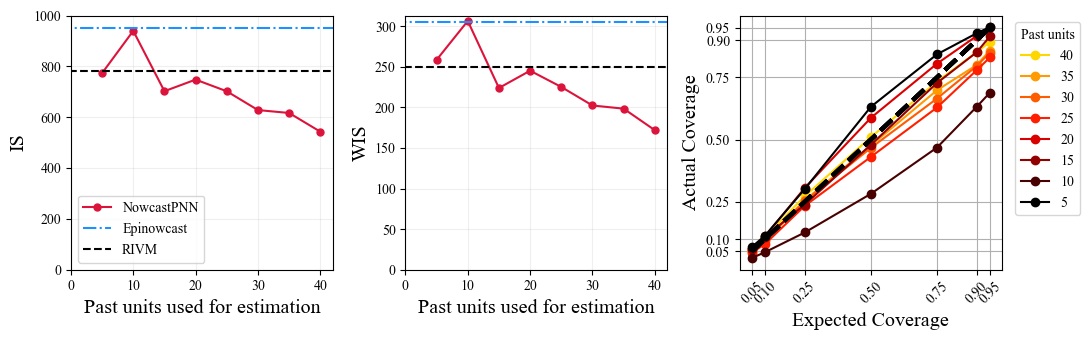

In [56]:
plot_past_units_is_wis_covs(n_past_units=n_past_units, pnn_is_decomp=pnn_is_decomp_rand, pnn_wis=pnn_wis_rand, pnn_coverages=pnn_coverages_rand, save = True, random_split=True)

## Again, random split but with 0.3, 0.1